<a href="https://colab.research.google.com/github/mcvlix/lorenz-96-hybrid-esn/blob/main/hybrid_rcesn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Mount your Drive ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# === Libraries ===
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tqdm import tqdm
from tqdm import trange
import torch
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse import linalg
from pathlib import Path
import gc
import pickle

In [3]:
# === Paths ===
project_path = '/content/drive/My Drive/AM170B Project'
data_path = os.path.join(project_path, 'data')
states_path = os.path.join(project_path, 'hybrid_states')
checkpoints_path = os.path.join(project_path, 'checkpoints')
models_path = os.path.join(project_path, 'models')
predictions_path = os.path.join(project_path, 'predictions')
plots_path = os.path.join(project_path, 'plots')
os.makedirs(states_path, exist_ok=True)
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)
os.makedirs(predictions_path, exist_ok=True)
os.makedirs(plots_path, exist_ok=True)

In [4]:
os.listdir(project_path)

['data',
 'checkpoints',
 'states',
 'models',
 'old_rcesn.ipynb',
 'predictions',
 'plots',
 'rcesn.ipynb',
 'hybrid_states',
 'hybrid_rcesn.ipynb']

In [5]:
# === View Memory Usage ===
def whos_memory(namespace):
    exclude = {
        'np', 'pd', 'plt', 'os', 'gc', 'sys', 'sio', 'tqdm', 'torch', 'sparse', 'Path',
        'exit', 'quit', 'open', 'get_ipython', 'whos_memory'
    }
    print(f"{'Variable':20} {'Type':15} {'Size (MB)':>10}")
    print("-" * 50)
    for name, val in namespace.items():
        if name.startswith("_") or name in exclude:
            continue
        try:
            size = sys.getsizeof(val) / 1024 / 1024
            print(f"{name:20} {type(val).__name__:15} {size:10.4f}")
        except Exception:
            print(f"{name:20} {type(val).__name__:15} {'<unknown>'}")

# del
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0001
Out                  dict                0.0002
drive                module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001


### ESN Parameters

In [6]:
# === Parameters ===
shift_k = 0  # Start index for initial condition
approx_res_size = 5000

model_params = {
    'tau': 0.25,
    'nstep': 1000,
    'N': 16, # 8 from model, 8 from data
    'd': 22
}

res_params = {
    'radius': 0.1,
    'degree': 3,
    'sigma': 0.5,
    'train_length': 500000,
    'N': int(np.floor(approx_res_size / model_params['N']) * model_params['N']),
    'num_inputs': model_params['N'],
    'predict_length': 1000,
    'beta': 0.0001
}

### Imperfect Model

In [36]:
# === Constants ===
K = 8
J = 8
F = 20
h = 0.5
c = 8
b = 10
dt = 0.005

# === Imperfect Step Function (Z excluded) ===
def step_imperfect(x_vec, y_mat):
    minus = [-1, 0, 1, 2, 3, 4, 5, 6]
    minus2 = [-2, -1, 0, 1, 2, 3, 4, 5]
    plus = [1, 2, 3, 4, 5, 6, 7, 0]
    plus2 = [2, 3, 4, 5, 6, 7, 0, 1]

    x_minus = x_vec[minus]
    x_minus2 = x_vec[minus2]
    x_plus = x_vec[plus]

    y_plus = y_mat[plus, :]
    y_plus2 = y_mat[plus2, :]
    y_minus = y_mat[minus, :]
    y_k = np.sum(y_mat, 0)

    dx = x_minus * (x_plus - x_minus2) - x_vec + F - (h * c / b) * y_k
    dy = -c * b * y_plus * (y_plus2 - y_minus) - c * y_mat + (h * c / b) * x_vec  # no z_kj
    dy = np.clip(dy, -1000, 1000)
    return dx, dy


def rk4_step(X, Y, step_func, dt):
    dx1, dy1 = step_func(X, Y)

    Rx2 = X + 0.5 * dt * dx1
    Ry2 = Y + 0.5 * dt * dy1
    dx2, dy2 = step_func(Rx2, Ry2)

    Rx3 = X + 0.5 * dt * dx2
    Ry3 = Y + 0.5 * dt * dy2
    dx3, dy3 = step_func(Rx3, Ry3)

    Rx4 = X + dt * dx3
    Ry4 = Y + dt * dy3
    dx4, dy4 = step_func(Rx4, Ry4)

    X_next = X + (dt / 6.0) * (dx1 + 2*dx2 + 2*dx3 + dx4)
    Y_next = Y + (dt / 6.0) * (dy1 + 2*dy2 + 2*dy3 + dy4)

    return X_next, Y_next

### Utilities

In [8]:
# === Utilities ===
def generate_reservoir(size, radius, degree):
    print("Generating Reservoir")
    sparsity = degree / float(size)
    A = sparse.rand(size, size, density=sparsity).todense()
    eigvals = np.linalg.eigvals(A)
    A = (A / np.max(np.abs(eigvals))) * radius
    return A

def build_input_weights(N, num_inputs, sigma):
    print("Building Input Weights")
    q = int(N / num_inputs)
    Win = np.zeros((N, num_inputs))
    for i in range(num_inputs):
        np.random.seed(i)
        Win[i * q: (i + 1) * q, i] = sigma * (-1 + 2 * np.random.rand(q))
    return Win

def reservoir_layer(A, Win, data, Y_init, res_params, states=None):
    N = res_params['N']
    T = res_params['train_length']
    K = data.shape[0]
    dt = 0.005

    if states is None:
        states = np.zeros((N, T))
    X_model = np.zeros((T, K))

    X_model[0] = data[:, 0]
    Y = Y_init.copy()

    for t in trange(1, T, desc="Training reservoir (RK4 Hybrid)"):
        # Step imperfect model using RK4 and X_true[t-1]
        X_model[t], Y = rk4_step(data[:, t - 1], Y, step_imperfect, dt)

        # Construct hybrid input u(t) = [X_model[t], X_true[t]]
        u_t = np.hstack([X_model[t], data[:, t]])
        states[:, t] = np.tanh(A @ states[:, t - 1] + Win @ u_t)

    return states, X_model

# def train(res_params, r_states, X_model, X_true):
#     beta = res_params['beta']
#     N, T = r_states.shape
#     K = X_model.shape[1]

#     # === Apply r* nonlinearity in-place (just like original logic)
#     r_star = r_states.copy()
#     for j in trange(2, N - 2, desc="Transforming r*"):
#         if j % 2 == 0:
#             r_star[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

#     # === Design matrix: [X_model.T; r_star] → shape (K+N, T)
#     X = np.vstack([X_model.T, r_star])  # inputs
#     Y = X_true.T                        # targets (K x T)

#     # === Ridge regression with sparse identity
#     I = beta * sparse.identity(K + N)
#     U = X @ X.T + I
#     W_out = np.linalg.solve(U.toarray(), X @ Y.T)  # (K+N, K)

#     return W_out.T  # shape: (K x (K + N))

def train(res_params, r_states, X_model, X_true):
    beta = res_params['beta']
    N, T = r_states.shape
    K = X_model.shape[1]

    # === Transform r_states into r_star in-place
    for j in trange(2, N - 2, desc="Transforming r_states → r* in-place"):
        if j % 2 == 0:
            r_states[j, :] = r_states[j - 1, :] * r_states[j - 2, :]

    # === Build design matrix and target
    X = np.vstack([X_model.T, r_states])  # shape (K + N, T)
    Y = X_true                             # shape (K, T)

    I = beta * np.identity(K + N)        # Dense identity matrix
    U = np.dot(X, X.T) + I
    W_out = np.dot(np.linalg.inv(U), np.dot(X, Y.T))  # (K + N, K)

    return W_out.T  # shape: (K, K + N)


### Usage

In [9]:
# === Usage ===

# Load training data
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
truth_data = np.load(npy_path)                         # shape: (T, 72)

# Extract X_true and Y_init
X_true = truth_data[:res_params['train_length'], :K].T  # shape: (K, T)
Y_init = truth_data[0, K:].reshape(J, K)                # shape: (J, K)

# Clean up raw data to free memory
del truth_data
gc.collect()

41

In [15]:
# Generate reservoir and input weights
A = generate_reservoir(res_params['N'], res_params['radius'], res_params['degree'])
Win = build_input_weights(res_params['N'], res_params['num_inputs'], res_params['sigma'])

Generating Reservoir
Building Input Weights


In [22]:
# Run reservoir with hybrid inputs (X_model + X_true)
r_states, X_model = reservoir_layer(A, Win, X_true, Y_init, res_params)

Training reservoir (RK4 Hybrid): 100%|██████████| 499999/499999 [1:04:24<00:00, 129.39it/s]


In [23]:
# === Save Reservoir Checkpoint ===
checkpoint_file = os.path.join(checkpoints_path, 'hybrid_checkpoint_500000.npz')
np.savez_compressed(checkpoint_file, A=A, Win=Win)

In [24]:
# Save reservoir states
np.savez_compressed( os.path.join(states_path, 'r_states_hybrid.npz'), r_states=r_states)
np.savez_compressed(os.path.join(states_path, 'X_model_hybrid.npz'), X_model=X_model)

In [18]:
# Optional: free memory
del A, Win
gc.collect()

0

In [10]:
r_states = np.load(os.path.join(states_path, 'r_states_hybrid.npz'))['r_states']
X_model = np.load(os.path.join(states_path, 'X_model_hybrid.npz'))['X_model']

In [12]:
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
K                    int                 0.0000
J                    int             

In [11]:
# Train output weights
W_out = train(res_params, r_states, X_model, X_true)

Transforming r_states → r* in-place: 100%|██████████| 4988/4988 [00:04<00:00, 1121.92it/s]


In [15]:
print("X_model.T", X_model.T.shape)
print("r_states", r_states.shape)
print("X_true.T", X_true.T.shape)

X_model.T (8, 500000)
r_states (4992, 500000)
X_true.T (500000, 8)


In [ ]:
del r_states, X_model, X_true
gc.collect()

### Save States and Model

In [13]:
# Save model components
checkpoint = np.load(os.path.join(checkpoints_path, 'hybrid_checkpoint_500000.npz'))
A = checkpoint['A']
Win = checkpoint['Win']

model_file = os.path.join(models_path, 'hybrid_model.npz')
np.savez_compressed(model_file, A=A, Win=Win, W_out=W_out)

In [14]:
del r_states, A, Win, W_out
gc.collect()

22

In [15]:
whos_memory(globals())

Variable             Type             Size (MB)
--------------------------------------------------
In                   list                0.0002
Out                  dict                0.0002
drive                module              0.0001
trange               function            0.0001
linalg               module              0.0001
pickle               module              0.0001
project_path         str                 0.0001
data_path            str                 0.0001
states_path          str                 0.0001
checkpoints_path     str                 0.0001
models_path          str                 0.0001
predictions_path     str                 0.0001
plots_path           str                 0.0001
shift_k              int                 0.0000
approx_res_size      int                 0.0000
model_params         dict                0.0002
res_params           dict                0.0003
K                    int                 0.0000
J                    int             

### Prediction

In [20]:
# Load model
model = np.load(os.path.join(models_path, 'hybrid_model.npz'))
A = model['A']
Win = model['Win']
W_out = model['W_out']

# Load initial condition from .npy file
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
init = np.load(npy_path)[500001]
X_init = init[:K]
Y_init = init[K:].reshape(J, K)

In [21]:
def predict_hybrid(A, Win, W_out, X_init, Y_init, step_func, rk4_step, res_params):
    K = res_params['num_inputs'] // 2  # Only half of inputs are X_true
    N = res_params['N']
    T_pred = res_params['predict_length']
    dt = 0.005

    # === Allocate
    X_preds = np.zeros((K, T_pred))
    r = np.zeros((N,))
    X = X_init.copy()
    Y = Y_init.copy()

    for t in tqdm(range(T_pred), desc="Hybrid Prediction"):
        # Step imperfect model
        X_model, Y = rk4_step(X, Y, step_func, dt)

        # Input to reservoir: u = [X_model, X]
        u = np.hstack([X_model, X])
        r = np.tanh(A @ r + Win @ u)

        # Construct r* (same rule as training)
        r_star = r.copy()
        for j in range(2, N - 2):
            if j % 2 == 0:
                r_star[j] = r[j - 1] * r[j - 2]

        # Output: X = W_out @ [X_model; r*]
        hybrid_input = np.hstack([X_model, r_star])
        X = W_out @ hybrid_input

        # Store prediction
        X_preds[:, t] = X

    return X_preds


In [22]:
# === Run Prediction ===
X_preds = predict_hybrid(
    A=A,
    Win=Win,
    W_out=W_out,
    X_init=X_init,
    Y_init=Y_init,
    step_func=step_imperfect,
    rk4_step=rk4_step,
    res_params=res_params
)

# === Save Prediction ===
pred_file = os.path.join(predictions_path, 'X_preds_hybrid.npz')
np.savez_compressed(pred_file, X_preds=X_preds)

# === Optional: Free memory
del model, A, Win, W_out, init, X_init, Y_init
gc.collect()

Hybrid Prediction: 100%|██████████| 1000/1000 [00:09<00:00, 108.26it/s]


0

In [19]:
def plot_hybrid_prediction(X_true, X_pred, start, res_params, plots_path):
    X_diff = X_true - X_pred

    time_axis = np.arange(start, start + res_params['predict_length'])
    space_axis = np.arange(res_params['num_inputs'] // 2)  # K = 8 for hybrid

    fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

    # --- True ---
    c1 = axs[0].contourf(time_axis, space_axis, X_true, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[0].set_title("True $X_k$ (from timestep {})".format(start))
    axs[0].set_ylabel("$X_k$")
    axs[0].set_yticks(space_axis)
    axs[0].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    cb1 = fig.colorbar(c1, ax=axs[0])
    cb1.set_ticks([-2, 0, 2])

    # --- Predicted ---
    c2 = axs[1].contourf(time_axis, space_axis, X_pred, levels=50, cmap='bwr', vmin=-2.5, vmax=2.5)
    axs[1].set_title("Hybrid ESN Prediction")
    axs[1].set_ylabel("$X_k$")
    axs[1].set_yticks(space_axis)
    axs[1].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    cb2 = fig.colorbar(c2, ax=axs[1])
    cb2.set_ticks([-2, 0, 2])

    # --- Difference ---
    c3 = axs[2].contourf(time_axis, space_axis, X_diff, levels=50, cmap='seismic', vmin=-2.5, vmax=2.5)
    axs[2].set_title("Difference: $X_{\\text{true}} - X_{\\text{pred}}$")
    axs[2].set_xlabel("Timesteps")
    axs[2].set_ylabel("$X_k$")
    axs[2].set_yticks(space_axis)
    axs[2].set_yticklabels([f"$X_{{{i}}}$" for i in space_axis])
    cb3 = fig.colorbar(c3, ax=axs[2])
    cb3.set_ticks([-2, 0, 2])

    # === Save and show ===
    plot_filename = f'prediction_plot_start{start}_len{res_params["predict_length"]}.png'
    plt.tight_layout()
    plt.savefig(os.path.join(plots_path, plot_filename), dpi=300)
    plt.show()

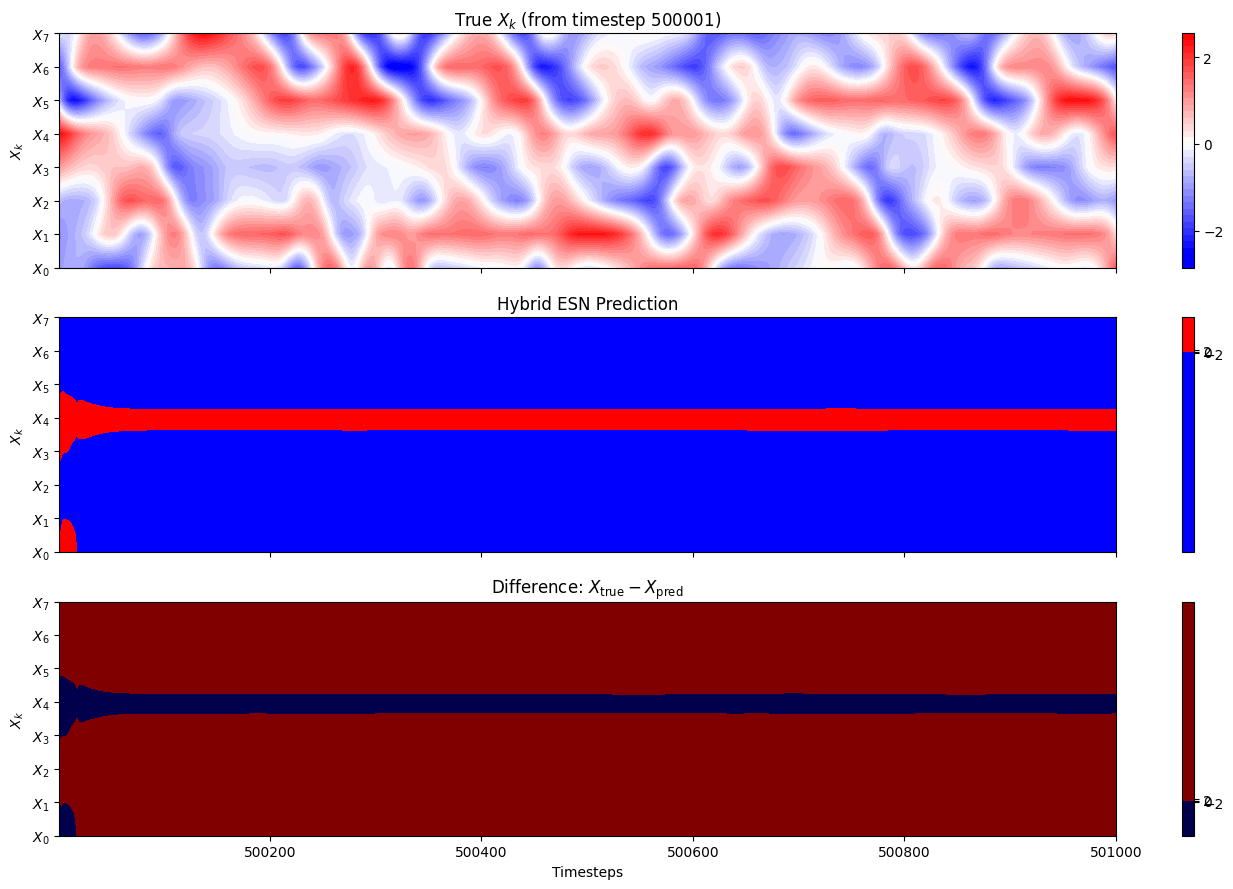

In [23]:
# === Load truth data
truth_data = np.load(npy_path)
start = 500001  # Since you used the first timestep
X_true = truth_data[start:start + res_params['predict_length'], :K].T

# === Load predictions
X_pred = np.load(os.path.join(predictions_path, 'X_preds_hybrid.npz'))['X_preds']

# === Plot
plot_hybrid_prediction(X_true, X_pred, start, res_params, plots_path)


Starting imperfect RK4 simulation...


Imperfect RK4: 100%|██████████| 1000/1000 [00:00<00:00, 5649.15it/s]


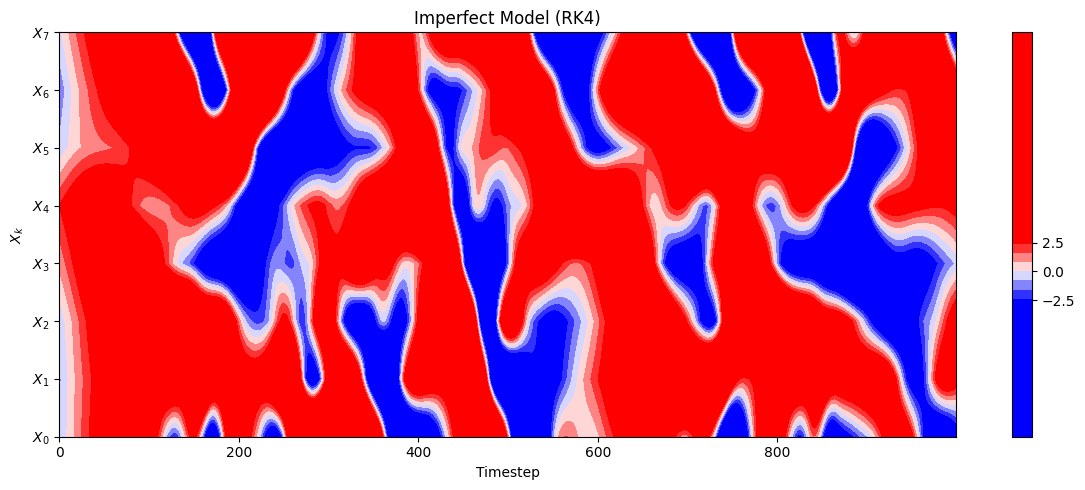

In [43]:
# === Load initial condition
data_path = '/content/drive/My Drive/AM170B Project/data'
npy_path = os.path.join(data_path, 'truth_h_0.5_c_8_F_20.npy')
init = np.load(npy_path)[500001]
X_vec = init[:K]
Y_mat = init[K:].reshape(J, K)
steps = 1000

# === Allocate storage
x_store = np.zeros((steps, K))

# === Imperfect RK4 Simulation
print("Starting imperfect RK4 simulation...")
for i in tqdm(range(steps), desc="Imperfect RK4"):
    dx1, dy1 = step_imperfect(X_vec, Y_mat)

    Rx2 = X_vec + 0.5 * dt * dx1
    Ry2 = Y_mat + 0.5 * dt * dy1
    dx2, dy2 = step_imperfect(Rx2, Ry2)

    Rx3 = X_vec + 0.5 * dt * dx2
    Ry3 = Y_mat + 0.5 * dt * dy2
    dx3, dy3 = step_imperfect(Rx3, Ry3)

    Rx4 = X_vec + dt * dx3
    Ry4 = Y_mat + dt * dy3
    dx4, dy4 = step_imperfect(Rx4, Ry4)

    X_vec += (dt / 6.0) * (dx1 + 2*dx2 + 2*dx3 + dx4)
    Y_mat += (dt / 6.0) * (dy1 + 2*dy2 + 2*dy3 + dy4)

    x_store[i, :] = X_vec

# === Plotting
def plot_imperfect_X_contour(X_test, title="Imperfect Model (RK4)", vmin=-2.5, vmax=2.5):
    T, K = X_test.shape
    time_axis = np.arange(T)
    space_axis = np.arange(K)

    plt.figure(figsize=(12, 5))
    c = plt.contourf(time_axis, space_axis, X_test.T, levels=50, cmap='bwr', vmin=vmin, vmax=vmax)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("$X_k$")
    plt.yticks(space_axis, [f"$X_{{{i}}}$" for i in space_axis])
    plt.colorbar(c, ticks=[vmin, 0, vmax])
    plt.tight_layout()
    plt.show()

# === Call the plot
plot_imperfect_X_contour(x_store)